### Preparation

In [ ]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116


In [167]:
# !wget --no-check-certificate \
#   https://drive.google.com/file/d/1OwZAi5DqmPmAcOjPRY5er1ZK0HWiDkSj/view?usp=sharing?cnn_model.pth \
#   -O cnn_model.pth

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import necessary libraries

In [1]:
import torch
import torchvision
import numpy as np
from PIL import ImageFilter
from sklearn.metrics import classification_report
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from torch import optim
from tqdm import tqdm
from torch import flatten
import zipfile,os
import time

In [5]:
# zip extraction
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Dataset_ML/vegetable_datasets_750.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [6]:
data_dir = "/content/vegetable_datasets"

In [7]:
train_ds = ImageFolder(data_dir+'/train', transform=ToTensor())
val_ds = ImageFolder(data_dir+'/validation', transform=ToTensor())
test_ds = ImageFolder(data_dir+'/test', transform=ToTensor())

In [ ]:
train_ds

Dataset ImageFolder
    Number of datapoints: 750
    Root location: /content/vegetable_datasets/train
    StandardTransform
Transform: ToTensor()

### Data Exploration

In [ ]:
classes = ['Broccoli', 'Cabbage', 'Cucumber']

Melihat isi folder

In [ ]:
broccoli_files = os.listdir(data_dir + "/train/Broccoli")
print('No. of training examples for Broccoli:', len(broccoli_files))
print(broccoli_files[:5])

No. of training examples for Broccoli: 250
['0175.jpg', '0019.jpg', '0116.jpg', '0224.jpg', '0033.jpg']


Load data sebagai Pytorch Tensor

In [ ]:
img, label = train_ds[0]
print(img.shape, label)
img

torch.Size([3, 224, 224]) 0


tensor([[[0.2627, 0.4549, 0.5255,  ..., 0.3608, 0.3765, 0.3765],
         [0.4157, 0.4588, 0.3647,  ..., 0.3647, 0.3686, 0.3765],
         [0.5451, 0.4667, 0.3686,  ..., 0.3608, 0.3647, 0.3608],
         ...,
         [0.3765, 0.4078, 0.4706,  ..., 0.5412, 0.5608, 0.5137],
         [0.3765, 0.4118, 0.4667,  ..., 0.5333, 0.6000, 0.4157],
         [0.3804, 0.4118, 0.4667,  ..., 0.4863, 0.5647, 0.5490]],

        [[0.3569, 0.5490, 0.6196,  ..., 0.3137, 0.3176, 0.3176],
         [0.5098, 0.5529, 0.4588,  ..., 0.3176, 0.3176, 0.3176],
         [0.6392, 0.5608, 0.4627,  ..., 0.3176, 0.3216, 0.3176],
         ...,
         [0.4941, 0.5255, 0.5882,  ..., 0.6196, 0.6314, 0.5843],
         [0.5059, 0.5294, 0.5843,  ..., 0.6118, 0.6706, 0.4863],
         [0.5098, 0.5294, 0.5843,  ..., 0.5569, 0.6353, 0.6196]],

        [[0.2314, 0.4235, 0.4863,  ..., 0.2275, 0.2431, 0.2431],
         [0.3843, 0.4196, 0.3255,  ..., 0.2314, 0.2431, 0.2431],
         [0.5059, 0.4275, 0.3294,  ..., 0.2314, 0.2353, 0.

Memeriksa kelas

In [ ]:
print(val_ds.classes)

['Broccoli', 'Cabbage', 'Cucumber']


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("Agg")
%matplotlib inline

# matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
def show_example(img, label):
    print('Label: ', train_ds.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    # plt.imshow(img)

Label:  Broccoli (0)


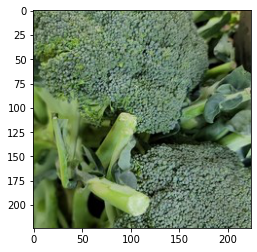

In [ ]:
show_example(*train_ds[0])

Label:  Cabbage (1)


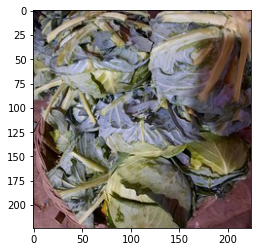

In [ ]:
show_example(*train_ds[1099])

### Define CNN

In [16]:
class CNNModel(nn.Module):
    def __init__(self, numChannels, classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=20,
          kernel_size=(5, 5))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50,
          kernel_size=(5, 5))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.fc1 = nn.Linear(in_features=140450, out_features=64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=64, out_features=classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        
        x = self.fc2(x)
        output = self.logSoftmax(x)
        return output

In [9]:
# hyperparameters
LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 15

# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### New Training

In [10]:
trainDataLoader = DataLoader(train_ds, shuffle=True,
	batch_size=BATCH_SIZE)
valDataLoader = DataLoader(val_ds, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(test_ds, batch_size=BATCH_SIZE)

trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

In [166]:
model = CNNModel(
	numChannels=3,
	classes=len(train_ds.classes)).to(device)

opt = optim.Adam(model.parameters(), lr=LR)
lossFn = nn.NLLLoss()

H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}

startTime = time.time()

In [ ]:
for e in range(0, EPOCHS):
    model.train()
    totalTrainLoss = 0
    totalValLoss = 0
    
    trainCorrect = 0
    valCorrect = 0
    for (x, y) in trainDataLoader:
        (x, y) = (x.to(device), y.to(device))
        pred = model(x)
        loss = lossFn(pred, y)

        opt.zero_grad()
        loss.backward()
        opt.step()
        
        totalTrainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(
          torch.float).sum().item()
    with torch.no_grad():
        model.eval()
        for (x, y) in valDataLoader:
            (x, y) = (x.to(device), y.to(device))
            pred = model(x)
            totalValLoss += lossFn(pred, y)
            valCorrect += (pred.argmax(1) == y).type(
              torch.float).sum().item()
    
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    
    trainCorrect = trainCorrect / len(trainDataLoader.dataset)
    valCorrect = valCorrect / len(valDataLoader.dataset)
    
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_acc"].append(trainCorrect)
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_acc"].append(valCorrect)
    
    print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
      avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
      avgValLoss, valCorrect))

[INFO] EPOCH: 1/15
Train loss: 1.520134, Train accuracy: 0.4600
Val loss: 1.180678, Val accuracy: 0.5948

[INFO] EPOCH: 2/15
Train loss: 0.800216, Train accuracy: 0.6733
Val loss: 0.652439, Val accuracy: 0.8824

[INFO] EPOCH: 3/15
Train loss: 0.448262, Train accuracy: 0.8467
Val loss: 0.665454, Val accuracy: 0.7712

[INFO] EPOCH: 4/15
Train loss: 0.373790, Train accuracy: 0.8480
Val loss: 0.489842, Val accuracy: 0.9020

[INFO] EPOCH: 5/15
Train loss: 0.226278, Train accuracy: 0.9307
Val loss: 0.326739, Val accuracy: 0.9281

[INFO] EPOCH: 6/15
Train loss: 0.116684, Train accuracy: 0.9720
Val loss: 0.249546, Val accuracy: 0.9477

[INFO] EPOCH: 7/15
Train loss: 0.099873, Train accuracy: 0.9707
Val loss: 0.337854, Val accuracy: 0.9150

[INFO] EPOCH: 8/15
Train loss: 0.102820, Train accuracy: 0.9680
Val loss: 0.280794, Val accuracy: 0.9216

[INFO] EPOCH: 9/15
Train loss: 0.052828, Train accuracy: 0.9907
Val loss: 0.219272, Val accuracy: 0.9542

[INFO] EPOCH: 10/15
Train loss: 0.026151, Trai

In [ ]:
endTime = time.time()
print("[INFO] Total time taken to train the model: {:.2f}s".format(
	endTime - startTime))
print("[INFO] Evaluating network...")
with torch.no_grad():
	# set the model in evaluation mode
	model.eval()
	
	# initialize a list to store our predictions
	preds = []
	for (x, y) in testDataLoader:
		# send the input to the device
		x = x.to(device)
		# make the predictions and add them to the list
		pred = model(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())
# generate a classification report
clf = classification_report(test_ds.targets, np.array(preds), target_names=test_ds.classes)
print(clf)

[INFO] total time taken to train the model: 1373.74s
[INFO] evaluating network...
              precision    recall  f1-score   support

    Broccoli       0.98      0.92      0.95        50
     Cabbage       0.78      0.94      0.85        50
    Cucumber       0.95      0.82      0.88        50

    accuracy                           0.89       150
   macro avg       0.91      0.89      0.89       150
weighted avg       0.91      0.89      0.89       150



In [ ]:
endTime = time.time()
print("[INFO] Total time taken to train the model: {:.2f}s".format(
	endTime - startTime))
print("[INFO] Evaluating network...")
with torch.no_grad():
	model.eval()
	preds = []
	for (x, y) in valDataLoader:
		x = x.to(device)
		pred = model(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())
	
clf = classification_report(val_ds.targets, np.array(preds), target_names=test_ds.classes)
print(clf)

[INFO] total time taken to train the model: 1931.16s
[INFO] evaluating network...
              precision    recall  f1-score   support

    Broccoli       0.94      0.98      0.96        50
     Cabbage       0.92      0.91      0.91        53
    Cucumber       0.96      0.94      0.95        50

    accuracy                           0.94       153
   macro avg       0.94      0.94      0.94       153
weighted avg       0.94      0.94      0.94       153



Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(val_ds.targets, np.array(preds))
cm

array([[49,  1,  0],
       [ 3, 48,  2],
       [ 0,  3, 47]])

<AxesSubplot:>

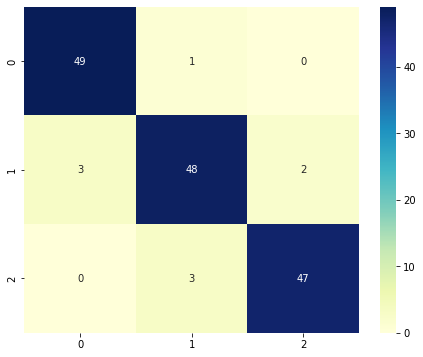

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(7.5,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', ax=ax)

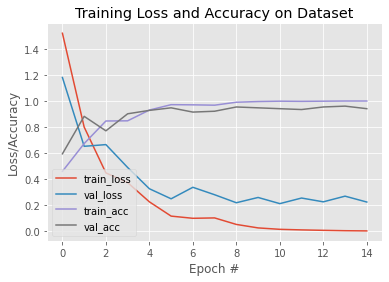

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

### Save Model

In [ ]:
torch.save(model, open('cnn_model.pth', 'wb'))

### Testing

In [14]:
from google.colab import files
mdl = files.upload()

Saving cnn_model.pth to cnn_model.pth


In [17]:
model1 = torch.load(open('cnn_model.pth', 'rb'))
model1.eval()

CNNModel(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=140450, out_features=64, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=64, out_features=3, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)

Test Image

In [25]:
with torch.no_grad():
	# loop over the test set
	for (image1, label) in testDataLoader:
		gtLabel = test_ds.classes[label.numpy()[0]]
		image = image1.to(device)
		pred = model1(image)

		idx = pred.argmax(axis=1).cpu().numpy()[0]
		predLabel = test_ds.classes[idx]
		scores = F.softmax(pred, dim=1)
		max_score= torch.max(scores)
		origImage = np.dstack([image1] * 3)

		print("[INFO] ground truth label: {}, predicted label: {}, confidence: {}".format(
			gtLabel, predLabel, max_score))

[INFO] ground truth label: Broccoli, predicted label: Broccoli, confidence: 1.0
[INFO] ground truth label: Cabbage, predicted label: Cabbage, confidence: 1.0
[INFO] ground truth label: Cucumber, predicted label: Cucumber, confidence: 0.9999998807907104


Predict image

In [156]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import matplotlib.pyplot as plt

def preds(image_path,model):
   img = Image.open(image_path)
   transform_norm = transforms.Compose([transforms.ToTensor()]) 
   # get normalized image
   img_normalized = transform_norm(img).float()
   img_normalized = img_normalized.unsqueeze_(0)
   img_normalized = img_normalized.to(device)
   with torch.no_grad():
      model.eval()  
      output =model(img_normalized)
      index = output.data.cpu().numpy().argmax()
      classes = train_ds.classes
      class_name = classes[index]
      scores = F.softmax(pred, dim=1)
      max_score= torch.max(scores)

      return class_name, max_score

In [161]:
from matplotlib import image

[INFO] predicted label: Cucumber, confidence: 1.0


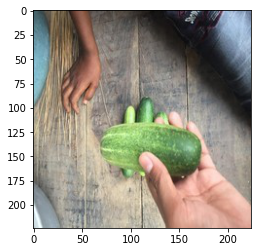

In [164]:
predict_class, score = preds('/content/vegetable_datasets/test/Cucumber/1013.jpg',torch.load(open('cnn_model.pth', 'rb')))
print("[INFO] predicted label: {}, confidence: {}".format(predict_class, score))
f = image.imread('/content/vegetable_datasets/test/Cucumber/1013.jpg')

plt.imshow(f)
plt.show()